In [317]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pickle
import torch
from torchvision import datasets, transforms
from sklearn.metrics import confusion_matrix, f1_score

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)


# Adam Optimizer

In [318]:
class Adam:
    def __init__(self, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.t = 0

    def update(self, param, grad, m, v):
        self.t += 1
        
        m = self.beta1 * m + (1 - self.beta1) * grad
        v = self.beta2 * v + (1 - self.beta2) * np.square(grad)
        
        m_hat = m / (1 - self.beta1**self.t)
        v_hat = v / (1 - self.beta2**self.t)
        
        param -= self.learning_rate * m_hat / (np.sqrt(v_hat) + self.epsilon)
        
        return param, m, v

# Dense Layer

In [319]:
class DenseLayer :
    def __init__(self, input_dimension, output_dimension, learning_rate=0.001):
        self.input_dimension = input_dimension
        self.output_dimension = output_dimension
        self.weights = np.random.randn(input_dimension, output_dimension) * np.sqrt(2.0 / input_dimension)
        self.output = None
        self.input = None
        self.biases = np.zeros((1, output_dimension))
        self.adam = Adam(learning_rate=learning_rate)
        
        # For Adam optimizer
        self.m_w = np.zeros_like(self.weights)
        self.v_w = np.zeros_like(self.weights)
        self.m_b = np.zeros_like(self.biases)
        self.v_b = np.zeros_like(self.biases)

    def forward(self, input):
        self.input = input
        self.output = np.dot(input, self.weights) + self.biases
        return self.output
    
    def backward(self, upstream_gradient):
        gradient_weights = np.dot(self.input.T, upstream_gradient)
        gradient_biases = np.sum(upstream_gradient, axis=0, keepdims=True)
        gradient_input = np.dot(upstream_gradient, self.weights.T)
        self.weights, self.m_w, self.v_w = self.adam.update(self.weights, gradient_weights, self.m_w, self.v_w)
        self.biases, self.m_b, self.v_b = self.adam.update(self.biases, gradient_biases, self.m_b, self.v_b)
        
        return gradient_input


# Batch Normalization

In [320]:
class BatchNormalization:
    def __init__(self, input_dimension, epsilon=1e-8, momentum=0.9, learning_rate=0.001):
        self.input_dimension = input_dimension
        self.epsilon = epsilon
        self.momentum = momentum
        self.beta = np.zeros((1, input_dimension))
        self.gamma = np.ones((1, input_dimension))
        self.batch_mean = None
        self.batch_variance = None
        self.normalized_input = None
        self.output = None
        self.running_mean = np.zeros((1, input_dimension))
        self.running_variance = np.ones((1, input_dimension))
        # For Adam optimizer
        self.m_gamma = np.zeros_like(self.gamma)
        self.v_gamma = np.zeros_like(self.gamma)
        self.m_beta = np.zeros_like(self.beta)
        self.v_beta = np.zeros_like(self.beta)
        self.adam = Adam(learning_rate=learning_rate)
    
    def forward(self, input, training=True):
        self.input = input
        if training:
            self.batch_mean = np.mean(input, axis=0)
            self.batch_variance = np.var(input, axis=0)
            self.running_mean = self.momentum * self.running_mean + (1 - self.momentum) * self.batch_mean
            self.running_variance = self.momentum * self.running_variance + (1 - self.momentum) * self.batch_variance
            mean = self.batch_mean
            variance = self.batch_variance
        else:
            mean = self.running_mean
            variance = self.running_variance
        self.normalized_input = (input - mean) / np.sqrt(variance + self.epsilon)
        self.output = self.gamma * self.normalized_input + self.beta
        return self.output
    
    def backward(self, upstream_gradient):
        batch_size = upstream_gradient.shape[0]
        gradient_normalized_input = upstream_gradient * self.gamma
        gradient_variance = np.sum(gradient_normalized_input * (self.input - self.batch_mean) * -0.5 * np.power(self.batch_variance+self.epsilon, -1.5), axis=0)
        gradient_mean = np.sum(gradient_normalized_input * -1 / np.sqrt(self.batch_variance+self.epsilon), axis=0) + gradient_variance * np.mean(-2 * (self.input - self.batch_mean), axis=0)
        gradient_input = gradient_normalized_input / np.sqrt(self.batch_variance+self.epsilon) + gradient_variance * 2 * (self.input - self.batch_mean) / batch_size + gradient_mean / batch_size
        gradiant_gamma= np.sum(upstream_gradient * self.normalized_input, axis=0)
        gradiant_beta =  np.sum(upstream_gradient, axis=0)
        self.gamma, self.m_gamma, self.v_gamma = self.adam.update(self.gamma, gradiant_gamma, self.m_gamma, self.v_gamma)
        self.beta, self.m_beta, self.v_beta = self.adam.update(self.beta, gradiant_beta, self.m_beta, self.v_beta)
        return gradient_input


# RELU

In [321]:
class ReLU:
    def __init__(self):
        self.input = None
        self.output = None
    
    def forward(self, input):
        self.input = input
        self.output = np.maximum(0, input)
        return self.output
    
    def backward(self, gradient):
        return gradient * (self.input > 0)

# DropOut

In [322]:
class Dropout:
    def __init__(self, dropout_rate=0.5):
        self.dropout_rate = dropout_rate
        self.mask = None
        self.input = None
        self.output = None
    
    def forward(self, input, training=True):
        self.input = input
        if training:
            self.mask = np.random.rand(*input.shape) > self.dropout_rate
            self.output = input * self.mask / (1 - self.dropout_rate)
        else:
            self.output = input
        return self.output
    
    def backward(self, upstream_gradient):
        return upstream_gradient * self.mask / (1 - self.dropout_rate)

# SoftMax

In [323]:
class Softmax:
    def __init__(self):
        self.input = None
        self.output = None
        self.exp_values = None

    def forward(self, input):
        self.input = input
        self.exp_values = np.exp(input - np.max(input, axis=1, keepdims=True))
        self.output = self.exp_values / np.sum(self.exp_values, axis=1, keepdims=True)
        return self.output

    def backward(self, y_labels):
        batch_size = self.output.shape[0]
        grad = self.output.copy()
        grad[range(batch_size), y_labels] -= 1
        return grad / batch_size
        

# Neural Network

In [324]:
class NeuralNetwork:
    def __init__(self):
        self.layers = []

    def add(self, layer):
        self.layers.append(layer)

    def forward(self, X, training=True):
        for layer in self.layers:
            if isinstance(layer, Dropout):
                X = layer.forward(X, training)
            else:
                X = layer.forward(X)
        return X

    def backward(self, gradient):
        for layer in reversed(self.layers):
            gradient = layer.backward(gradient)

    def save_weights(self, filename):
        weights_and_biases = []
        for layer in self.layers:
            if isinstance(layer, DenseLayer):
                weights_and_biases.append(layer.weights)
                weights_and_biases.append(layer.biases)
            if isinstance(layer, BatchNormalization):
                weights_and_biases.append(layer.gamma)
                weights_and_biases.append(layer.beta)
        with open(filename, 'wb') as f:
            pickle.dump(weights_and_biases, f)
        
    def load_weights(self, filename):
        with open(filename, 'rb') as f:
            weights_and_biases = pickle.load(f)
        # print(len(weights_and_biases))
        # print()
        # print(weights_and_biases)
        j=0
        for i, layer in enumerate(self.layers):
            if isinstance(layer, DenseLayer):
                # print('weights_and_biases[2*j]', [2*j])
                layer.weights = weights_and_biases[2*j]
                layer.biases = weights_and_biases[2*j+1]
                j+=1
            if isinstance(layer, BatchNormalization):
                # print('weights_and_biases[2*j]', [2*j])
                layer.gamma = weights_and_biases[2*j]
                layer.beta = weights_and_biases[2*j+1]
                j+=1

In [ ]:
def load_fashion_mnist():
    train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True)  
    X_train = train_dataset.data.numpy().reshape(-1, 28*28) / 255.0
    y_train = train_dataset.targets.numpy()
    test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True)
    X_test = test_dataset.data.numpy().reshape(-1, 28*28) / 255.0
    y_test = test_dataset.targets.numpy()
    
    return (X_train, y_train), (X_test, y_test)

In [326]:
def create_batches(X, y, batch_size):
    indices = np.random.permutation(len(X))
    for i in range(0, len(X), batch_size):
        batch_idx = indices[i:i + batch_size]
        yield X[batch_idx], y[batch_idx]

In [327]:
# Define model architecture
def create_model(input_dim=784, hidden_dims=[512, 256], output_dim=10, dropout_rate=0.3, learning_rate=0.001):
    model = NeuralNetwork()
    
    # Input layer
    model.add(DenseLayer(input_dim, hidden_dims[0], learning_rate=learning_rate))
    model.add(BatchNormalization(hidden_dims[0], learning_rate=learning_rate))
    model.add(ReLU())
    model.add(Dropout(dropout_rate))
    
    # Hidden layers
    for i in range(len(hidden_dims)-1):
        model.add(DenseLayer(hidden_dims[i], hidden_dims[i+1], learning_rate=learning_rate))
        model.add(BatchNormalization(hidden_dims[i+1], learning_rate=learning_rate))
        model.add(ReLU())
        model.add(Dropout(dropout_rate))
    
    # Output layer
    model.add(DenseLayer(hidden_dims[-1], output_dim, learning_rate=learning_rate))
    model.add(Softmax())

    return model

# Evaluate function


In [328]:
def predict(model, X, y, training=False):
    output = model.forward(X, training)
    predicted_class = np.argmax(output, axis=1)
    loss = np.mean(-np.log(output[range(len(y)), y]))
    return predicted_class, loss

# evaluate function
def evaluate(model, X, y, batch_size=128):
    total_loss = 0
    predictions = []
#     criterion = CrossEntropyLoss()
    
    for i in range(0, len(X), batch_size):
        batch_X = X[i:i + batch_size]
        batch_y = y[i:i + batch_size]
        
        pred, loss = predict(model, batch_X, batch_y)
        total_loss += loss * len(batch_X)
        
        predictions.extend(pred)
    
    acc = np.mean(np.array(predictions) == y)
    avg_loss = total_loss / len(X)
    macro_f1 = f1_score(y, predictions, average='macro')
    
    return avg_loss, acc, macro_f1, predictions



In [329]:
# Training function
def train_model(model, X_train, y_train, X_val, y_val, epochs=30, batch_size=128, learning_rate=0.001):

    history = {
        'train_loss': [], 'train_acc': [], 'train_f1': [],
        'val_loss': [], 'val_acc': [], 'val_f1': []
    }
    
    for epoch in range(epochs):
        # Training
        train_losses = []
        train_predictions = []
        
        for batch_X, batch_y in tqdm(create_batches(X_train, y_train, batch_size), 
                                   desc=f'Epoch {epoch+1}/{epochs}'):
            # Forward pass
            pred, loss = predict(model, batch_X, batch_y, training=True)
            train_losses.append(loss)
            
            # Store predictions
            train_predictions.extend(pred)
            
            # Backward pass
#             grad = criterion.backward(batch_y)
            model.backward(batch_y)
#             model.update_parameters()
        
        # Calculate training metrics
        train_loss = np.mean(train_losses)
        train_acc = np.mean(np.array(train_predictions) == y_train[:len(train_predictions)])
        train_f1 = f1_score(y_train[:len(train_predictions)], train_predictions, average='macro')
        
        # Validation metrics
        val_loss, val_acc, val_f1, _ = evaluate(model, X_val, y_val, batch_size)
        
        # Store metrics
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['train_f1'].append(train_f1)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_f1'].append(val_f1)
        
        print(f'\nEpoch {epoch+1}/{epochs}:')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Train F1: {train_f1:.4f}')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}')
    
    return history

In [330]:
def find_best_model(learning_rates, architectures, X_train, y_train, X_val, y_val):
    results = {}
    best_val_f1 = 0
    best_model = None
    best_config = None

    for lr in learning_rates:
        for i, arch in enumerate(architectures):
            print(f"\nTraining model with lr={lr} and architecture {i+1}/{len(architectures)}")

            model = create_model(**arch, learning_rate=lr)
            history = train_model(model, X_train, y_train, X_val, y_val, learning_rate=lr)

            val_f1 = history['val_f1'][-1]
            print(f"Validation F1 Score: {val_f1:.4f}")

            results[f'lr_{lr}_arch_{i+1}'] = {
                'history': history,
                'val_f1': val_f1
            }

            if val_f1 > best_val_f1:
                best_val_f1 = val_f1
                best_model = model
                best_config = {'lr': lr, 'arch': arch}

            # Generate and save the 4 figures
            plt.figure(figsize=(12, 4))

            # Accuracy
            plt.subplot(1, 4, 1)
            plt.plot(history['train_acc'], label='Train')
            plt.plot(history['val_acc'], label='Val')
            plt.title('Accuracy')
            plt.xlabel('Epoch')
            plt.ylabel('Accuracy')
            plt.legend()

            # Loss
            plt.subplot(1, 4, 2)
            plt.plot(history['train_loss'], label='Train')
            plt.plot(history['val_loss'], label='Val')
            plt.title('Loss')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.legend()

            # F1 Score
            plt.subplot(1, 4, 3)
            plt.plot(history['train_f1'], label='Train')
            plt.plot(history['val_f1'], label='Val')
            plt.title('F1 Score')
            plt.xlabel('Epoch')
            plt.ylabel('F1 Score')
            plt.legend()

            # Confusion Matrix
            plt.subplot(1, 4, 4)
            _, _, _, val_predictions = evaluate(model, X_val, y_val, batch_size=128)
            cm = confusion_matrix(y_val, val_predictions)
            sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
            plt.title('Confusion Matrix')
            plt.xlabel('Predicted')
            plt.ylabel('Actual')

            plt.tight_layout()
            plt.show()
            plt.close()

    print(f"\nBest model configuration: {best_config}")
    print(f"Best validation F1 score: {best_val_f1:.4f}")

    # Save the best model
    best_model.save_weights('best_model_weights.pkl')
    # Save the config
    with open('best_model_config.pkl', 'wb') as f:
        pickle.dump(best_config, f)

    return results, best_model, best_config


Training model with lr=0.001 and architecture 1/1


Epoch 1/30: 391it [00:21, 18.31it/s]



Epoch 1/30:
Train Loss: 0.5149, Train Acc: 0.0984, Train F1: 0.0984
Val Loss: 0.3848, Val Acc: 0.8595, Val F1: 0.8583


Epoch 2/30: 391it [00:22, 17.33it/s]



Epoch 2/30:
Train Loss: 0.3837, Train Acc: 0.0990, Train F1: 0.0989
Val Loss: 0.3499, Val Acc: 0.8702, Val F1: 0.8701


Epoch 3/30: 391it [00:21, 18.41it/s]



Epoch 3/30:
Train Loss: 0.3444, Train Acc: 0.0996, Train F1: 0.0996
Val Loss: 0.3371, Val Acc: 0.8751, Val F1: 0.8737


Epoch 4/30: 391it [00:21, 18.13it/s]



Epoch 4/30:
Train Loss: 0.3240, Train Acc: 0.1007, Train F1: 0.1007
Val Loss: 0.3154, Val Acc: 0.8829, Val F1: 0.8827


Epoch 5/30: 391it [00:23, 16.36it/s]



Epoch 5/30:
Train Loss: 0.3004, Train Acc: 0.0990, Train F1: 0.0990
Val Loss: 0.3216, Val Acc: 0.8821, Val F1: 0.8829


Epoch 6/30: 391it [00:20, 19.21it/s]



Epoch 6/30:
Train Loss: 0.2846, Train Acc: 0.0987, Train F1: 0.0987
Val Loss: 0.3139, Val Acc: 0.8854, Val F1: 0.8859


Epoch 7/30: 391it [00:20, 18.99it/s]



Epoch 7/30:
Train Loss: 0.2732, Train Acc: 0.0988, Train F1: 0.0989
Val Loss: 0.3049, Val Acc: 0.8875, Val F1: 0.8868


Epoch 8/30: 391it [00:19, 20.18it/s]



Epoch 8/30:
Train Loss: 0.2627, Train Acc: 0.0989, Train F1: 0.0989
Val Loss: 0.3087, Val Acc: 0.8898, Val F1: 0.8903


Epoch 9/30: 391it [00:23, 16.63it/s]



Epoch 9/30:
Train Loss: 0.2541, Train Acc: 0.1033, Train F1: 0.1033
Val Loss: 0.3062, Val Acc: 0.8927, Val F1: 0.8922


Epoch 10/30: 391it [00:25, 15.04it/s]



Epoch 10/30:
Train Loss: 0.2424, Train Acc: 0.0993, Train F1: 0.0992
Val Loss: 0.3088, Val Acc: 0.8895, Val F1: 0.8904


Epoch 11/30: 391it [00:24, 16.13it/s]



Epoch 11/30:
Train Loss: 0.2324, Train Acc: 0.0990, Train F1: 0.0990
Val Loss: 0.3068, Val Acc: 0.8910, Val F1: 0.8909


Epoch 12/30: 391it [00:21, 17.90it/s]



Epoch 12/30:
Train Loss: 0.2257, Train Acc: 0.0973, Train F1: 0.0973
Val Loss: 0.3029, Val Acc: 0.8914, Val F1: 0.8911


Epoch 13/30: 391it [00:20, 18.71it/s]



Epoch 13/30:
Train Loss: 0.2214, Train Acc: 0.0990, Train F1: 0.0990
Val Loss: 0.2932, Val Acc: 0.8962, Val F1: 0.8967


Epoch 14/30: 391it [00:23, 16.89it/s]



Epoch 14/30:
Train Loss: 0.2116, Train Acc: 0.0979, Train F1: 0.0979
Val Loss: 0.3059, Val Acc: 0.8935, Val F1: 0.8943


Epoch 15/30: 391it [00:18, 21.15it/s]



Epoch 15/30:
Train Loss: 0.2033, Train Acc: 0.0987, Train F1: 0.0987
Val Loss: 0.3005, Val Acc: 0.8957, Val F1: 0.8960


Epoch 16/30: 391it [00:19, 20.00it/s]



Epoch 16/30:
Train Loss: 0.1986, Train Acc: 0.0958, Train F1: 0.0958
Val Loss: 0.3042, Val Acc: 0.8951, Val F1: 0.8953


Epoch 17/30: 391it [00:19, 20.18it/s]



Epoch 17/30:
Train Loss: 0.1916, Train Acc: 0.0978, Train F1: 0.0978
Val Loss: 0.3146, Val Acc: 0.8964, Val F1: 0.8972


Epoch 18/30: 391it [00:19, 20.48it/s]



Epoch 18/30:
Train Loss: 0.1878, Train Acc: 0.0991, Train F1: 0.0991
Val Loss: 0.3138, Val Acc: 0.8961, Val F1: 0.8959


Epoch 19/30: 391it [00:22, 17.58it/s]



Epoch 19/30:
Train Loss: 0.1780, Train Acc: 0.0999, Train F1: 0.0999
Val Loss: 0.3217, Val Acc: 0.8959, Val F1: 0.8970


Epoch 20/30: 391it [00:21, 18.57it/s]



Epoch 20/30:
Train Loss: 0.1732, Train Acc: 0.0998, Train F1: 0.0998
Val Loss: 0.3214, Val Acc: 0.8951, Val F1: 0.8947


Epoch 21/30: 391it [00:22, 17.63it/s]



Epoch 21/30:
Train Loss: 0.1713, Train Acc: 0.0997, Train F1: 0.0997
Val Loss: 0.3351, Val Acc: 0.8928, Val F1: 0.8929


Epoch 22/30: 391it [00:20, 19.09it/s]



Epoch 22/30:
Train Loss: 0.1691, Train Acc: 0.0991, Train F1: 0.0991
Val Loss: 0.3127, Val Acc: 0.9026, Val F1: 0.9030


Epoch 23/30: 391it [00:23, 16.98it/s]



Epoch 23/30:
Train Loss: 0.1633, Train Acc: 0.1023, Train F1: 0.1023
Val Loss: 0.3205, Val Acc: 0.8998, Val F1: 0.9008


Epoch 24/30: 391it [00:20, 19.36it/s]



Epoch 24/30:
Train Loss: 0.1582, Train Acc: 0.0991, Train F1: 0.0991
Val Loss: 0.3361, Val Acc: 0.8943, Val F1: 0.8949


Epoch 25/30: 391it [00:20, 19.45it/s]



Epoch 25/30:
Train Loss: 0.1542, Train Acc: 0.0983, Train F1: 0.0983
Val Loss: 0.3277, Val Acc: 0.8992, Val F1: 0.8996


Epoch 26/30: 391it [00:22, 17.63it/s]



Epoch 26/30:
Train Loss: 0.1491, Train Acc: 0.0994, Train F1: 0.0994
Val Loss: 0.3326, Val Acc: 0.8995, Val F1: 0.8995


Epoch 27/30: 391it [00:21, 18.44it/s]



Epoch 27/30:
Train Loss: 0.1450, Train Acc: 0.0990, Train F1: 0.0990
Val Loss: 0.3444, Val Acc: 0.8978, Val F1: 0.8976


Epoch 28/30: 391it [00:21, 17.97it/s]



Epoch 28/30:
Train Loss: 0.1384, Train Acc: 0.0999, Train F1: 0.0999
Val Loss: 0.3555, Val Acc: 0.8959, Val F1: 0.8963


Epoch 29/30: 391it [00:21, 17.93it/s]



Epoch 29/30:
Train Loss: 0.1378, Train Acc: 0.0975, Train F1: 0.0975
Val Loss: 0.3436, Val Acc: 0.9009, Val F1: 0.9011


Epoch 30/30: 391it [00:22, 17.59it/s]



Epoch 30/30:
Train Loss: 0.1351, Train Acc: 0.1016, Train F1: 0.1016
Val Loss: 0.3484, Val Acc: 0.8971, Val F1: 0.8974
Validation F1 Score: 0.8974


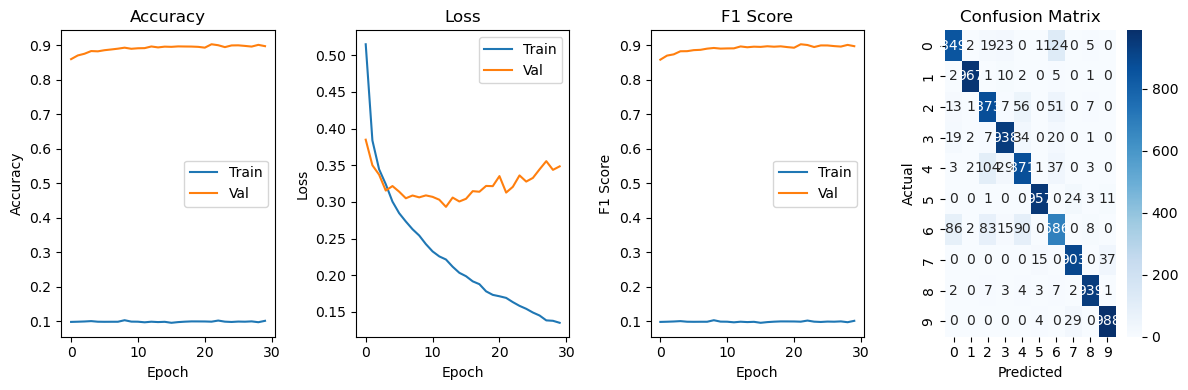


Best model configuration: {'lr': 0.001, 'arch': {'hidden_dims': [512, 256], 'dropout_rate': 0.3}}
Best validation F1 score: 0.8974


In [ ]:

# Load and preprocess data
(X_train, y_train), (X_test, y_test) = load_fashion_mnist()

val_size = 10000
X_val = X_train[-val_size:]
y_val = y_train[-val_size:]
X_train = X_train[:-val_size]
y_train = y_train[:-val_size]


# Train models with different learning rates and architectures
learning_rates = [0.003,0.001, 0.0005, 0.002]
# learning_rates = [0.001]

architectures = [
    {'hidden_dims': [512, 256], 'dropout_rate': 0.3},
    {'hidden_dims': [1024, 512, 256], 'dropout_rate': 0.4},
    {'hidden_dims': [256, 128], 'dropout_rate': 0.2}
]
# architectures = [
#     {'hidden_dims': [512, 256], 'dropout_rate': 0.3}
# ]


results, best_model, best_config = find_best_model(learning_rates, architectures, X_train, y_train, X_val, y_val)


# Evaluating on Test set

Test Loss: 0.3745
Test Accuracy: 0.8939
Test F1 Score: 0.8939


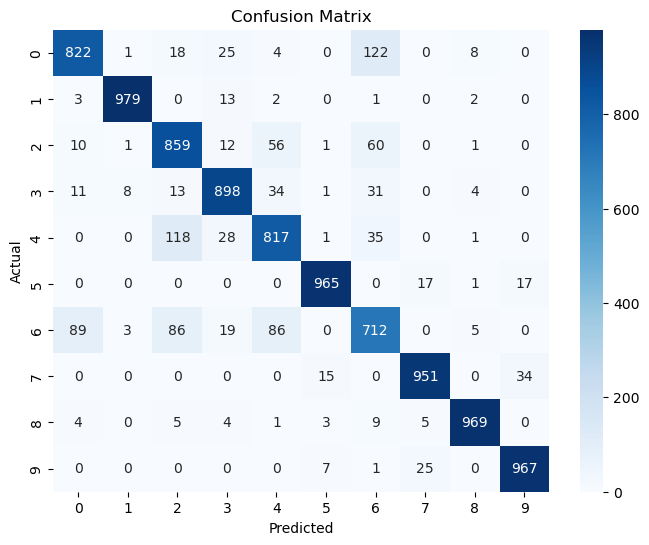

In [ ]:
# Load the best model configuration
with open('1905065_best_model_config.pkl', 'rb') as f:
    best_config = pickle.load(f)

# Load the best model
best_model = create_model(hidden_dims=best_config['arch']['hidden_dims'], dropout_rate=best_config['arch']['dropout_rate'], learning_rate=best_config['lr'])
# print('layer size',len(best_model.layers))
best_model.load_weights('1905065_best_model_weights.pkl')

# Evaluate the model on the test set
test_loss, test_acc, test_f1, test_predictions = evaluate(best_model, X_test, y_test)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")

# Print the confusion matrix
cm = confusion_matrix(y_test, test_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()